In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import os
import warnings
warnings.simplefilter('ignore')

### Load and Clean the Data
- Import raw dataset and transform it into the right format.
- I noticed that the columns were jumbled  that’s why I decided to split each line item based on Column Header

In [2]:
pwd = os.getcwd()

In [3]:
header = ["raw"]
df = pd.read_csv(os.path.basename(pwd +'/transactions.txt'),header=None, sep='\t', names=header)

In [4]:
df_subset = df.replace('"','', regex=True)

In [5]:
df_subset.raw = df_subset.raw.str[1:]
df_subset.raw = df_subset.raw.str[:-1]
df_subset.head()

,raw
0,"accountNumber: 737265056, customerId: 73726505..."
1,"accountNumber: 737265056, customerId: 73726505..."
2,"accountNumber: 737265056, customerId: 73726505..."
3,"accountNumber: 737265056, customerId: 73726505..."
4,"accountNumber: 830329091, customerId: 83032909..."


In [6]:
keys = ['accountnumber', 'customerid', 'creditlimit', 'availablemoney', 
        'transactiondatetime', 'transactionamount', 'merchantname', 'acqcountry',
        'merchantcountrycode', 'posentrymode', 'posconditioncode', 'merchantcategorycode',
        'currentexpdate', 'cardpresent', 'accountopendate', 'dateoflastaddresschange',
        'cardcvv', 'enteredcvv', 'cardlast4digits', 'transactiontype', 'echobuffer', 
        'currentbalance', 'merchantcity', 'merchantstate', 'merchantzip', 'cardpresent', 
        'posonpremises', 'recurringauthind', 'expirationdatekeyinmatch', 'isfraud']

- <b> Function parse_into_table:</b> Parse each line in Table and map each column with respective data
- <b> Function parse_raw       :</b> Split Columns at " , " and Column data at " : ".
- <b> Function map_to_list     :</b> Add column values to respective key

In [7]:
def parse_raw(raw_data):
    lines = raw_data.split(',')
    table = {}
    message = ''
    keys_to_extract = keys    
    for line in lines:
        
        pairs = line.split(':')  
        key = pairs[0].lower().replace(" ","")
        val = pairs[1].strip()
        
        if key in keys_to_extract:
            if val == '':
                table[key] = np.nan
            else:
                table[key] = val
    return table

In [8]:
def parse_into_table(data):
    table = [parse_raw(line) for line in data]
    return {
        key : map_to_list(table,key) for key in keys 
    }

In [9]:
def map_to_list(table, key):
    results = []
    for struc in table:
        
        if key not in struc:
            results.append('')
        else:
            results.append(struc[key])
    return results

In [10]:
df1 = pd.DataFrame(parse_into_table(df_subset.raw))

In [11]:
df1.head()

,accountnumber,customerid,creditlimit,availablemoney,transactiondatetime,transactionamount,merchantname,acqcountry,merchantcountrycode,posentrymode,...,transactiontype,echobuffer,currentbalance,merchantcity,merchantstate,merchantzip,posonpremises,recurringauthind,expirationdatekeyinmatch,isfraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14,98.55,Uber,US,US,02,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false
1,737265056,737265056,5000.0,5000.0,2016-10-11T05,74.51,AMC #191138,US,US,09,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false
2,737265056,737265056,5000.0,5000.0,2016-11-08T09,7.47,Play Store,US,US,09,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false
3,737265056,737265056,5000.0,5000.0,2016-12-10T02,7.47,Play Store,US,US,09,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false
4,830329091,830329091,5000.0,5000.0,2016-03-24T21,71.18,Tim Hortons #947751,US,US,02,...,PURCHASE,NaN,0.0,NaN,NaN,NaN,NaN,NaN,false,false


#### Structure of the data and Number of Null records 

In [12]:
"Dataset Dimensions: {}x{}".format(df1.shape[0], df1.shape[1])

'Dataset Dimensions: 786363x29'

In [13]:
df1.isnull().sum()

accountnumber                    0
customerid                       0
creditlimit                      0
availablemoney                   0
transactiondatetime              0
transactionamount                0
merchantname                     0
acqcountry                    4562
merchantcountrycode            724
posentrymode                  4054
posconditioncode               409
merchantcategorycode             0
currentexpdate                   0
cardpresent                      0
accountopendate                  0
dateoflastaddresschange          0
cardcvv                          0
enteredcvv                       0
cardlast4digits                  0
transactiontype                698
echobuffer                  786363
currentbalance                   0
merchantcity                786363
merchantstate               786363
merchantzip                 786363
posonpremises               786363
recurringauthind            786363
expirationdatekeyinmatch         0
isfraud             

Columns  <b> 'merchantcity', 'merchantstate', 'merchantzip', 'posonpremises', 'recurringauthind' and 'echobuffer' </b> are empty and removing these columns will have no effect on the final output

In [14]:
df1.drop(['merchantcity', 'merchantstate', 'merchantzip', 'posonpremises', 'recurringauthind', 'echobuffer'], axis=1, inplace=True)

In [15]:
df1[["creditlimit","transactionamount","availablemoney" ,"currentbalance"]] = df1[["creditlimit","transactionamount","availablemoney" ,  "currentbalance"]].apply(pd.to_numeric)

In [16]:
df1.dtypes

accountnumber                object
customerid                   object
creditlimit                 float64
availablemoney              float64
transactiondatetime          object
transactionamount           float64
merchantname                 object
acqcountry                   object
merchantcountrycode          object
posentrymode                 object
posconditioncode             object
merchantcategorycode         object
currentexpdate               object
cardpresent                  object
accountopendate              object
dateoflastaddresschange      object
cardcvv                      object
enteredcvv                   object
cardlast4digits              object
transactiontype              object
currentbalance              float64
expirationdatekeyinmatch     object
isfraud                      object
dtype: object

## Data Visualization

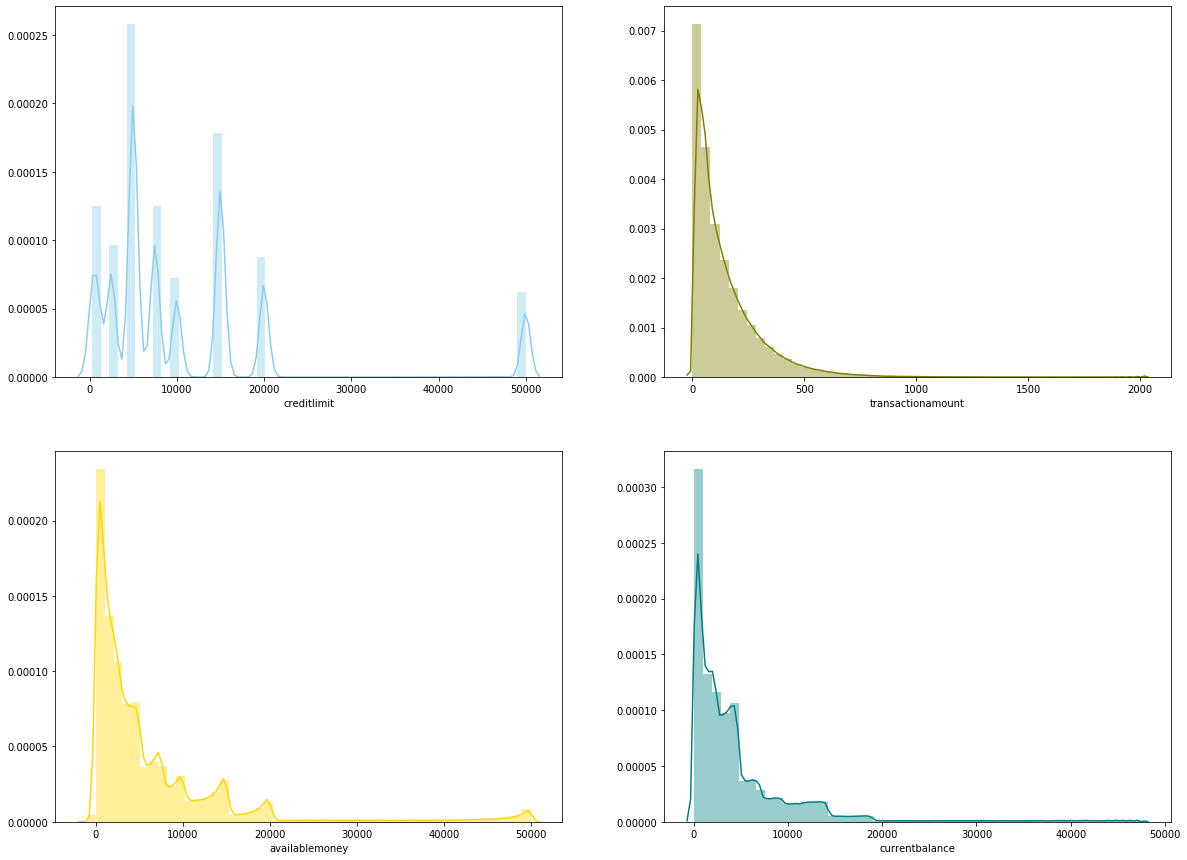

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))

sns.distplot( df1["creditlimit"] , color="skyblue", ax=ax[0, 0])
sns.distplot( df1["transactionamount"] , color="olive", ax=ax[0, 1])
sns.distplot( df1["availablemoney"] , color="gold", ax=ax[1, 0])
sns.distplot( df1["currentbalance"] , color="teal", ax=ax[1, 1])

Since columns does not a similar value range we can't use single Boxplot to desplay them all 

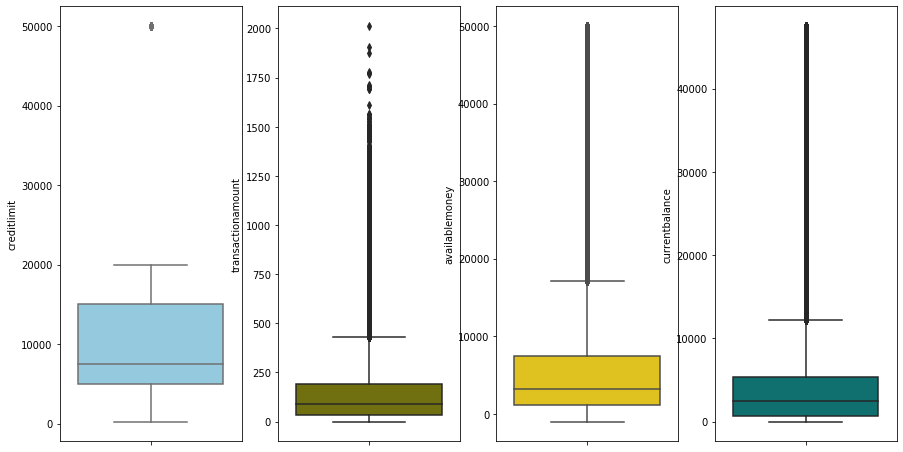

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(15,8))
sns.boxplot(ax=ax[0], x=df1['creditlimit'], orient='v',color="skyblue")
sns.boxplot(ax=ax[1], x=df1['transactionamount'], orient='v',color="olive")
sns.boxplot(ax=ax[2], x=df1['availablemoney'], orient='v',color="gold")
sns.boxplot(ax=ax[3], x=df1['currentbalance'], orient='v',color="teal")

### Hypotheses about the Data structure.
This Data certainly doesn’t follow a normal distribution and from the Box plot it is evident that Column Available money, Current Balance and Transactions have a lot of outliers

### Credit Limit
- Data have few Outliers
- Data is not Normally distributed
- Credit limit value is usually predefined by banks and it is evident from the data distribution

### Transaction Amount
- Data is highly Right skewed
- Majority of Transaction data closer to Zero, which implies that most of the customers don’t spend much

### Available Money
- Data is Right skewed
- If available credit is closer to 0, it means Customers don't have any/less credit for making purchases. This can happen if Customer maxed out their credit card

### Current Balance
- Data is Right skewed
- Current balance refers to all unpaid charges on an account, it makes sense that majority of the data have low current balance.

In [19]:
df1['creditlimit'].value_counts()

5000.0     201863
15000.0    139307
7500.0      97913
2500.0      75429
20000.0     68629
10000.0     56889
50000.0     48781
1000.0      36430
250.0       34025
500.0       27097
Name: creditlimit, dtype: int64

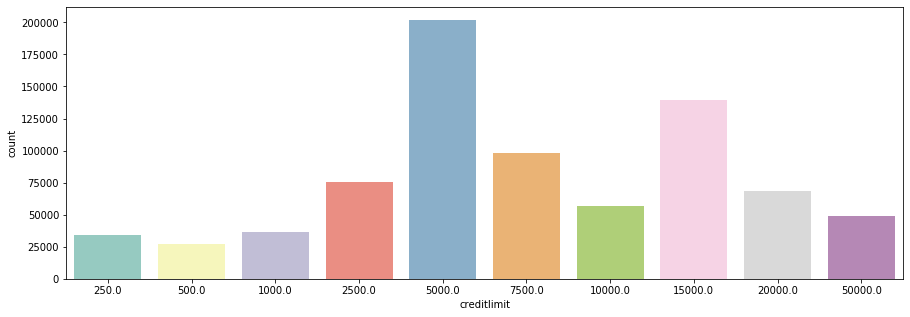

In [20]:
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(x="creditlimit", data=df1, palette="Set3")

### Distribution of Credit Limit among the Customers with Respect to Transaction Amount
- Assuming that people with low Credit limit will not Spend more, hence the Transaction Amount will be low.
- There are few Outliers as we can see in figure below, but most of the Transactions are under 500

Text(0, 0.5, 'Transaction Amount')

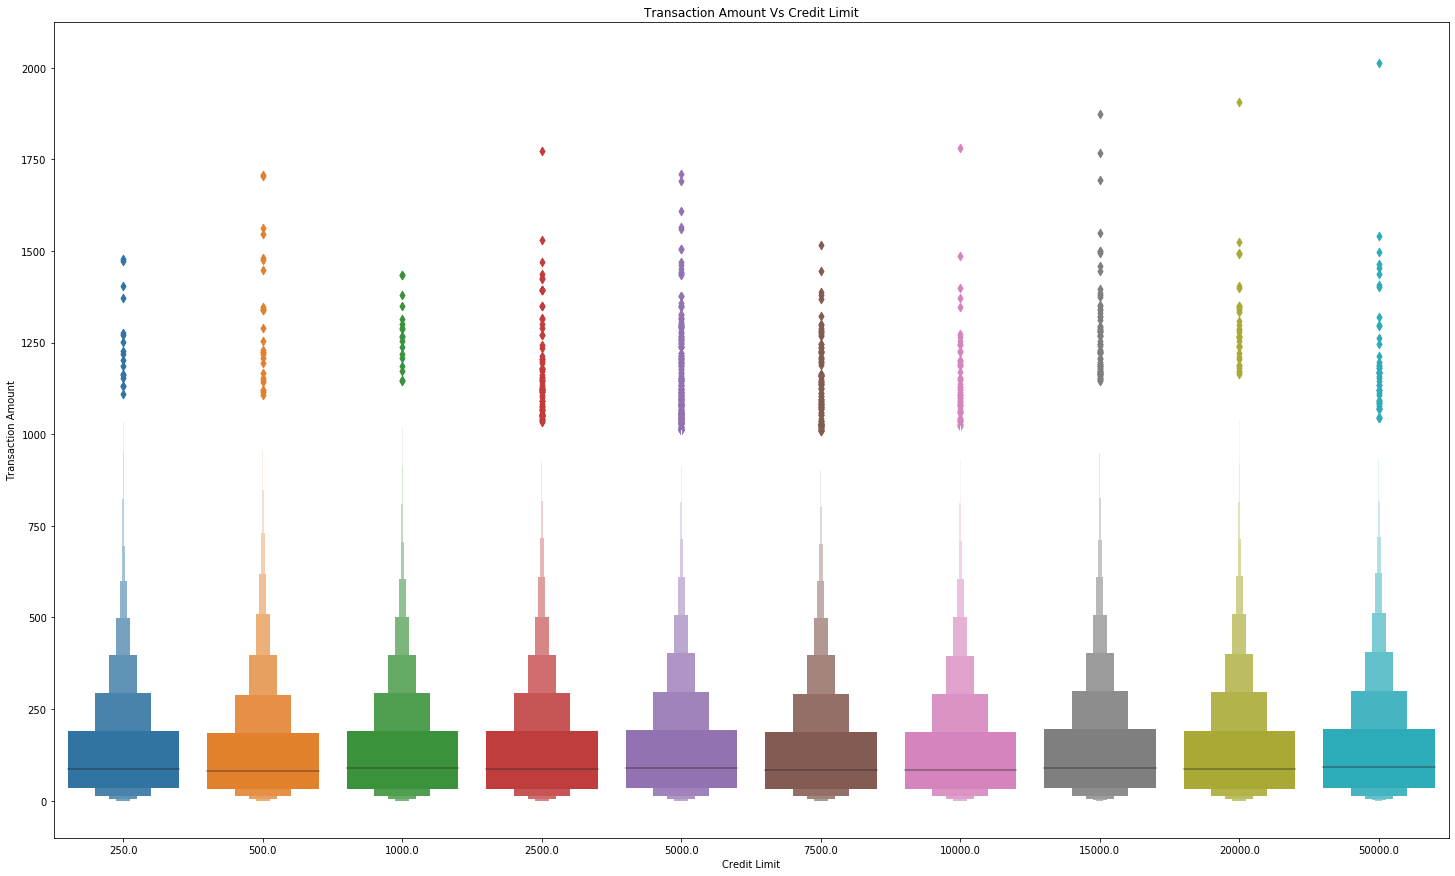

In [21]:
fig = plt.figure(figsize=(25,15)) 
sns.boxenplot(data=df1, x='creditlimit', y='transactionamount')
plt.title('Transaction Amount Vs Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Transaction Amount')

### This a data distribution by Merchant category code with majority data under Online retail category for Fraud and Not Fraud transactions

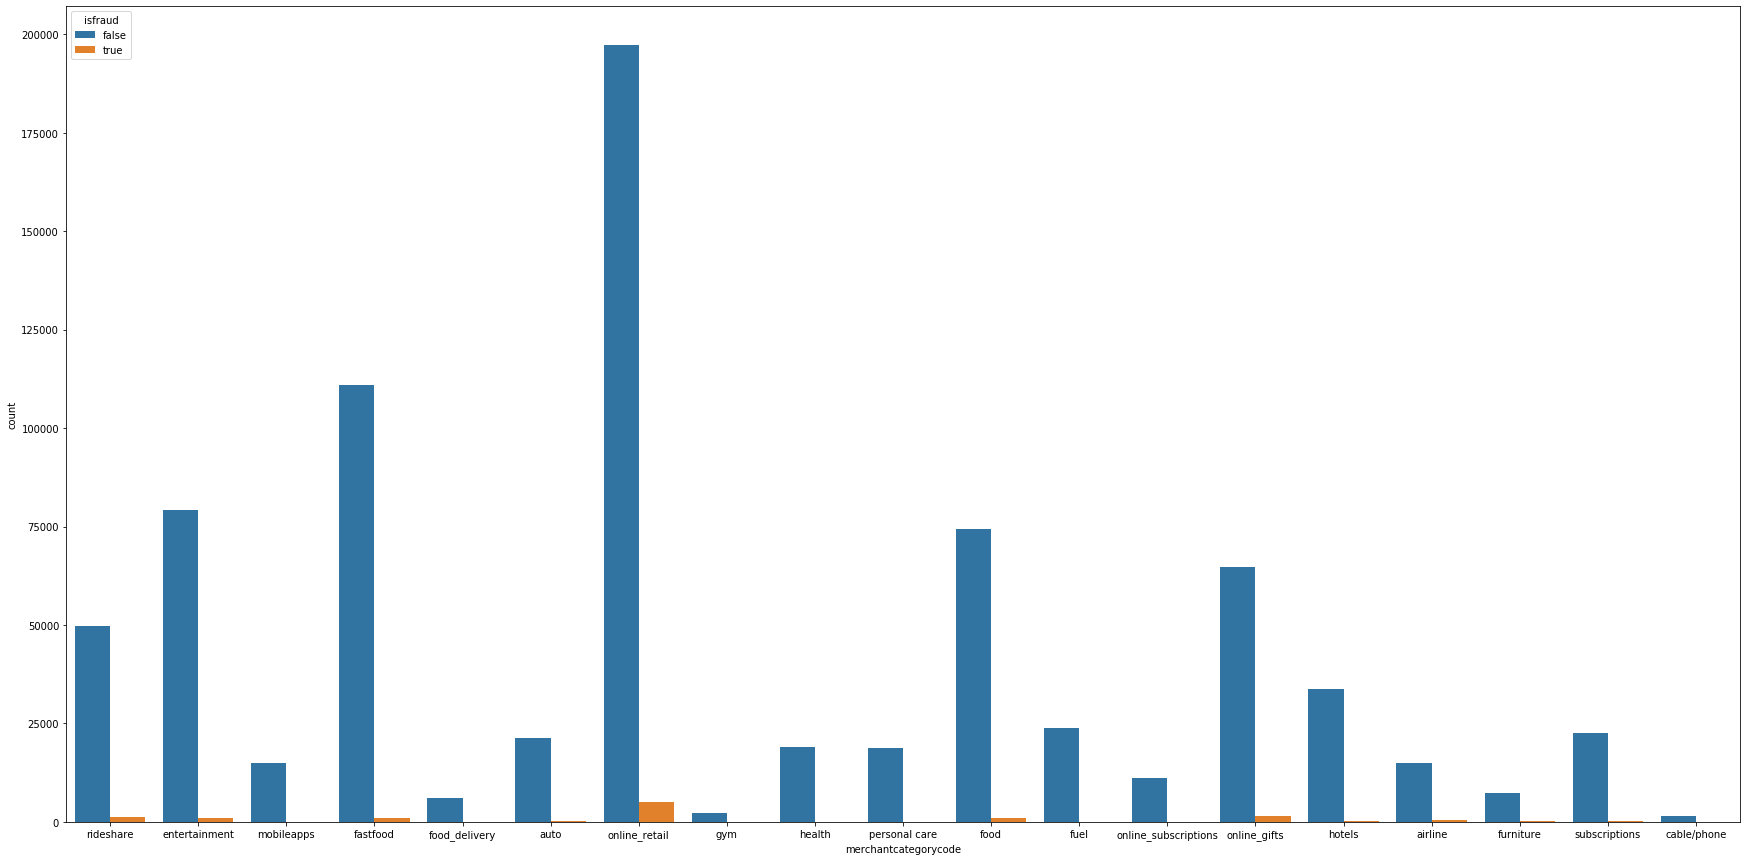

In [22]:
fig = plt.figure(figsize=(30,15)) 
ax = sns.countplot(x="merchantcategorycode",hue='isfraud' , data=df1)

### Box plot of Number of IsFraud Vs Not Fraud
- We can see that data is highly unbalanced with more than 95% as False and Rest as True

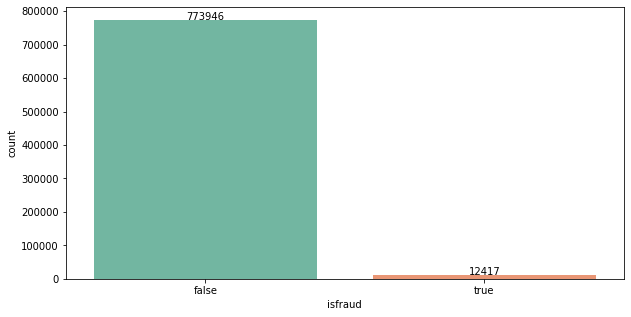

In [23]:
fig, ax1 = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax1,x='isfraud', data=df1,palette="Set2")
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Text(0.5, 1.0, 'POS Entry Mode')

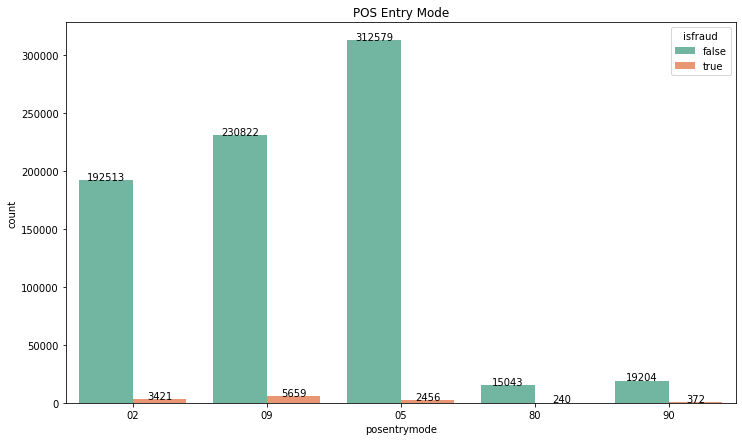

In [24]:
fig, ax1 = plt.subplots(figsize=(12,7))
graph =sns.countplot(data=df1, x='posentrymode', hue='isfraud',palette="Set2")
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.title('POS Entry Mode')

### Graph of Transaction Type and Fraudulent data
- Mean of Fraud transaction amount is more as compared to not Fraud Transaction.

Text(0.5, 1.0, 'Transaction Type')

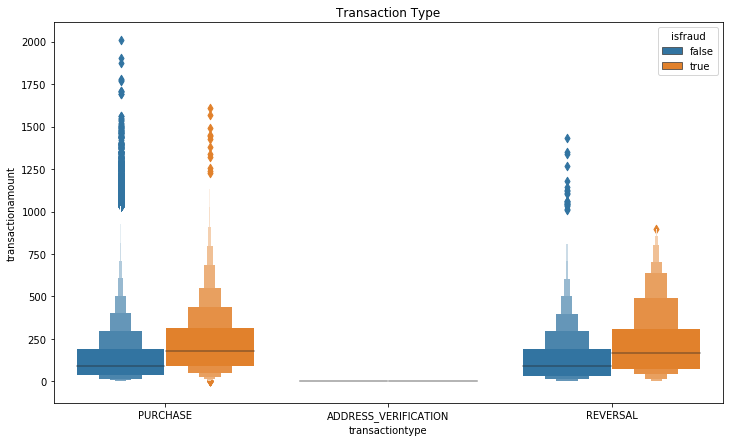

In [25]:
fig, ax1 = plt.subplots(figsize=(12,7))
sns.boxenplot(data=df1, y = 'transactionamount', x='transactiontype', hue='isfraud')
plt.title('Transaction Type')

### Graph: Transaction Type Vs Available money
- This graph has strangely similar distribution for all the Transaction Types

Text(0.5, 1.0, 'Transaction Type Vs Available money')

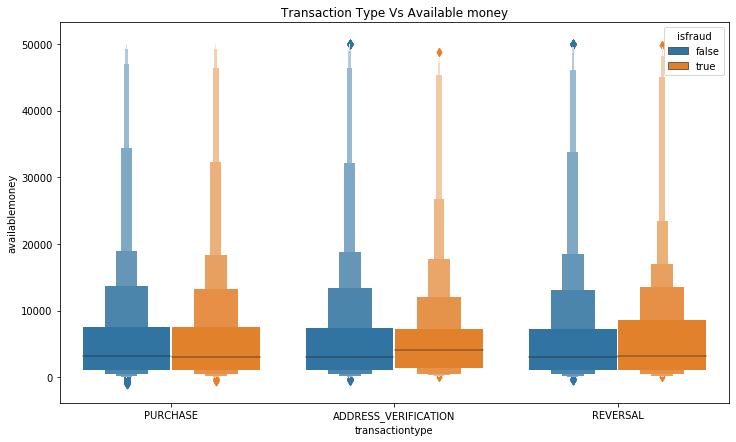

In [26]:
fig, ax1 = plt.subplots(figsize=(12,7))
sns.boxenplot(data=df1, y = 'availablemoney', x='transactiontype', hue='isfraud')
plt.title('Transaction Type Vs Available money')

Converting Binary variables 

In [27]:
df1['correct_cvv'] = df1['cardcvv'] == df1['enteredcvv']
for col in ['cardpresent', 'expirationdatekeyinmatch', 'isfraud']:
    df1[col] = df1[col].replace({'false': 0, 'true': 1})
df1['correct_cvv'] = df1['correct_cvv'].replace({False: 0, True: 1})

In [28]:
df1 = df1.dropna()

In [29]:
df1.drop(['cardcvv', 'enteredcvv','dateoflastaddresschange','accountopendate',
          'cardlast4digits','currentexpdate','merchantname'],axis=1, inplace=True)

In [30]:
df1.head()

,accountnumber,customerid,creditlimit,availablemoney,transactiondatetime,transactionamount,acqcountry,merchantcountrycode,posentrymode,posconditioncode,merchantcategorycode,cardpresent,transactiontype,currentbalance,expirationdatekeyinmatch,isfraud,correct_cvv
0,737265056,737265056,5000.0,5000.0,2016-08-13T14,98.55,US,US,02,01,rideshare,0,PURCHASE,0.0,0,0,1
1,737265056,737265056,5000.0,5000.0,2016-10-11T05,74.51,US,US,09,01,entertainment,1,PURCHASE,0.0,0,0,1
2,737265056,737265056,5000.0,5000.0,2016-11-08T09,7.47,US,US,09,01,mobileapps,0,PURCHASE,0.0,0,0,1
3,737265056,737265056,5000.0,5000.0,2016-12-10T02,7.47,US,US,09,01,mobileapps,0,PURCHASE,0.0,0,0,1
4,830329091,830329091,5000.0,5000.0,2016-03-24T21,71.18,US,US,02,01,fastfood,1,PURCHASE,0.0,0,0,1


### Data Wrangling - Duplicate Transactions

In [31]:
df_identify = df1.copy()
df_identify.drop(['acqcountry', 'merchantcountrycode','posentrymode',
          'expirationdatekeyinmatch','customerid'],axis=1, inplace=True)

- We have to identify Duplicate card swipes; I am filtering out non Card transactions and perform analysis just on swipe transaction.

In [32]:
df_identify = df_identify[df_identify['cardpresent'] == 1]
df_identify.head()

,accountnumber,creditlimit,availablemoney,transactiondatetime,transactionamount,posconditioncode,merchantcategorycode,cardpresent,transactiontype,currentbalance,isfraud,correct_cvv
1,737265056,5000.0,5000.0,2016-10-11T05,74.51,01,entertainment,1,PURCHASE,0.0,0,1
4,830329091,5000.0,5000.0,2016-03-24T21,71.18,01,fastfood,1,PURCHASE,0.0,0,1
5,830329091,5000.0,5000.0,2016-04-19T16,30.76,01,fastfood,1,PURCHASE,0.0,0,1
6,830329091,5000.0,5000.0,2016-05-21T14,57.28,01,fastfood,1,PURCHASE,0.0,0,1
7,830329091,5000.0,5000.0,2016-06-03T00,9.37,01,fastfood,1,PURCHASE,0.0,0,1


- Assuming there are no transactions in between the reversed and Multi-swipe transactions
- My approach to solve this problem is to start with 1 account number getting a desired output then use same methods for bulk data
- 570884863 has 9907 transaction details 
- Account number and CutomerID both the column has same details and hence one can be removed
- Removing unnecessary columns <b> 'posconditioncode','cardpresent','creditlimit','merchantcategorycode', 'transactiontype','isfraud','correct_cvv' <b/>

In [33]:
df_acct = df_identify[df_identify['accountnumber'] == '570884863']

df_acct.drop(['posconditioncode','cardpresent','creditlimit','merchantcategorycode',
          'transactiontype','isfraud','correct_cvv'],axis=1, inplace=True)

- Convert transactiondatetime column to just Date, as it would be easier to Group by date and get duplicate values

In [34]:
df_acct['time'] = pd.to_datetime(df_acct['transactiondatetime']).dt.time

df_acct['transactiondatetime'] = pd.to_datetime(df_acct['transactiondatetime']).dt.date

df_acct.sort_values(['accountnumber','transactiondatetime']).groupby(['accountnumber','transactiondatetime', 'transactionamount']).size().reset_index()

,accountnumber,transactiondatetime,transactionamount,0
0,570884863,2016-01-01,7.87,1
1,570884863,2016-01-01,17.35,1
2,570884863,2016-01-01,34.66,1
3,570884863,2016-01-01,36.46,1
4,570884863,2016-01-01,37.32,1
...,...,...,...,...
9705,570884863,2016-12-30,300.20,1
9706,570884863,2016-12-30,368.19,1
9707,570884863,2016-12-30,445.54,1
9708,570884863,2016-12-30,504.96,1


In [35]:
df_acct['flag'] = df_acct.transactionamount.groupby([df_acct.transactiondatetime,
                                                     df_acct.transactionamount.diff().ne(0).cumsum()]).transform('size').ge(2).astype(int) 
df_acct['flag'].value_counts()


0    9541
1     366
Name: flag, dtype: int64

#### In total there are 183 ( 366/2 : 362 is orignal plus Duplicate )  Duplicate Transactions just for 570884863
- Filter out Duplicate Normal transaction and its Duplicate Transaction
- Get the difference in Available money of Normal transaction and its Duplicate Transaction group by the Customer
- Remove Normal Transaction 
- Create a new column to Identify multi-swipe or reversed transaction


In [36]:
df_acct = df_acct[df_acct['flag'] == 1]

#Sort by Date and Time
df_acct['diff'] = df_acct.sort_values(['accountnumber','transactiondatetime' ,'time']).groupby(['accountnumber','transactiondatetime', 'transactionamount'])['availablemoney'].diff().fillna(0).astype(float)

# Getting just a Single transaction ( reversed/multi-swipe )
df_acct = df_acct[df_acct['diff'] != 0]

df_acct['identity'] = np.where(df_acct['diff'] > 0, 'multi-swipe','reversed')

# Positive is Multi-swipe 
# Negative is Reverse 
df_acct


,accountnumber,availablemoney,transactiondatetime,transactionamount,currentbalance,time,flag,diff,identity
650854,570884863,2441.37,2016-01-02,0.19,2558.63,02:00:00,1,-0.19,reversed
650902,570884863,2913.42,2016-01-03,125.98,2086.58,19:00:00,1,-125.98,reversed
650944,570884863,1929.77,2016-01-05,21.53,3070.23,07:00:00,1,-21.53,reversed
651001,570884863,757.43,2016-01-07,145.78,4242.57,01:00:00,1,-145.78,reversed
651012,570884863,3159.12,2016-01-07,265.03,1840.88,10:00:00,1,2835.12,multi-swipe
...,...,...,...,...,...,...,...,...,...
661453,570884863,855.93,2016-12-22,88.73,4144.07,19:00:00,1,-88.73,reversed
661558,570884863,446.16,2016-12-26,202.58,4553.84,12:00:00,1,-202.58,reversed
661601,570884863,1971.65,2016-12-28,302.20,3028.35,02:00:00,1,-302.20,reversed
661642,570884863,2485.21,2016-12-29,59.75,2514.79,06:00:00,1,-59.75,reversed


In [37]:
df_acct['identity'].value_counts()

reversed       174
multi-swipe     14
Name: identity, dtype: int64

## Total number of transactions for Customer :570884863
- Reversed       174
- Multi-swipe    14

In [38]:
df_acct['diff'][df_acct["identity"]=='reversed'].sum()

-22076.270000000004

## Total dollar amount of Reversed Transaction for Customer :570884863 = 22076


In [39]:
df_acct['diff'][df_acct["identity"]=='multi-swipe'].sum()

37880.25000000001

## Total dollar amount of Multi-Swipe Transaction for Customer :570884863 = 37880

## Applying same methods to Complete data :df_identify

In [40]:
## Removing columns

df_identify.drop(['posconditioncode','cardpresent','creditlimit','merchantcategorycode',
          'transactiontype','isfraud','correct_cvv'],axis=1, inplace=True)

## Convert Date and Time in sepacrate 2 columns
df_identify['time'] = pd.to_datetime(df_identify['transactiondatetime']).dt.time
df_identify['transactiondatetime'] = pd.to_datetime(df_identify['transactiondatetime']).dt.date


df_identify.sort_values(['accountnumber','transactiondatetime']).groupby(['accountnumber','transactiondatetime', 'transactionamount']).size().reset_index()

## Create Flag column to indentify Duplicate transactions
df_identify['flag'] = df_identify.transactionamount.groupby([df_identify.transactiondatetime,
                                                     df_identify.transactionamount.diff().ne(0).cumsum()]).transform('size').ge(2).astype(int) 

## Filtering out just Duplicate transactions
df_identify = df_identify[df_identify['flag'] == 1]

#Sort by Date and Time
df_identify['diff'] = df_identify.sort_values(['accountnumber','transactiondatetime' ,'time']).groupby(['accountnumber','transactiondatetime', 'transactionamount'])['availablemoney'].diff().fillna(0).astype(float)

# Getting just a Single transaction ( reversed/multi-swipe )
df_identify = df_identify[df_identify['diff'] != 0]

## Categorizing into reversed or multi-swipe
df_identify['identity'] = np.where(df_identify['diff'] > 0, 'multi-swipe','reversed')

In [41]:
df_identify

,accountnumber,availablemoney,transactiondatetime,transactionamount,currentbalance,time,flag,diff,identity
39,574788567,2200.98,2016-05-24,215.13,299.02,01:00:00,1,-215.13,reversed
263,984504651,26680.99,2016-03-12,118.52,23319.01,06:00:00,1,-118.52,reversed
264,984504651,26562.47,2016-03-12,118.52,23437.53,06:00:00,1,-118.52,reversed
281,984504651,24316.12,2016-03-18,26.71,25683.88,13:00:00,1,-26.71,reversed
413,984504651,7302.32,2016-05-07,23.82,42697.68,07:00:00,1,-23.82,reversed
...,...,...,...,...,...,...,...,...,...
785587,841351704,13979.93,2016-12-27,206.92,36020.07,18:00:00,1,-206.92,reversed
785649,698607813,2385.71,2016-09-17,29.20,114.29,17:00:00,1,-29.20,reversed
785915,428856030,104.44,2016-10-30,314.07,145.56,20:00:00,1,-135.41,reversed
786120,638498773,9798.21,2016-01-01,201.79,201.79,19:00:00,1,-201.79,reversed


In [42]:
df_identify['identity'].value_counts()

reversed       5642
multi-swipe     392
Name: identity, dtype: int64

## Total number of Duplicate transactions 
- Reversed       5642
- Multi-swipe     392

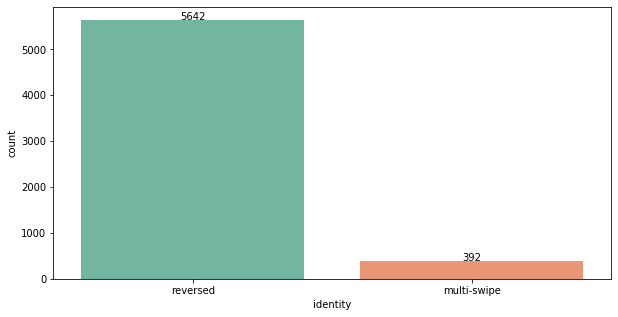

In [43]:
fig, ax1 = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax1,x='identity', data=df_identify,palette="Set2")
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

In [44]:
df_identify['diff'][df_identify["identity"]=='reversed'].sum()

-778848.6100000001

## Total dollar amount of Reversed Transaction  = 778848

In [45]:
df_identify['diff'][df_identify["identity"]=='multi-swipe'].sum()

582887.63

## Total dollar amount of Multi-Swipe Transaction  = 582887

### Preparing data for Model building

#### Removing columns which has no effect on the final output.
- Since accountNumber and customerId are a Unique identifier it will have no effect on the transaction being Fraud or Not.
- We have already removed in Data Wrangling step
<ul>
<li>Merchant Name have 25613 unique variables </li>
<li>Date Of Last AddressChange and cards last 4 digits has no effect on determining fraud </li>
</ul>


In [46]:
df1.drop(['accountnumber','customerid','transactiondatetime'],
         axis=1, inplace=True)

In [47]:
df1.isnull().sum()

creditlimit                 0
availablemoney              0
transactionamount           0
acqcountry                  0
merchantcountrycode         0
posentrymode                0
posconditioncode            0
merchantcategorycode        0
cardpresent                 0
transactiontype             0
currentbalance              0
expirationdatekeyinmatch    0
isfraud                     0
correct_cvv                 0
dtype: int64

In [48]:
df1 = df1.reindex(columns = ['creditlimit', 'availablemoney', 'transactionamount','currentbalance',
                  'acqcountry', 'merchantcountrycode', 'posentrymode', 'posconditioncode',
                  'merchantcategorycode', 'cardpresent', 'transactiontype', 
                  'expirationdatekeyinmatch','correct_cvv', 'isfraud'] )

In [49]:
df1.head()

,creditlimit,availablemoney,transactionamount,currentbalance,acqcountry,merchantcountrycode,posentrymode,posconditioncode,merchantcategorycode,cardpresent,transactiontype,expirationdatekeyinmatch,correct_cvv,isfraud
0,5000.0,5000.0,98.55,0.0,US,US,02,01,rideshare,0,PURCHASE,0,1,0
1,5000.0,5000.0,74.51,0.0,US,US,09,01,entertainment,1,PURCHASE,0,1,0
2,5000.0,5000.0,7.47,0.0,US,US,09,01,mobileapps,0,PURCHASE,0,1,0
3,5000.0,5000.0,7.47,0.0,US,US,09,01,mobileapps,0,PURCHASE,0,1,0
4,5000.0,5000.0,71.18,0.0,US,US,02,01,fastfood,1,PURCHASE,0,1,0


In [50]:
"Dataset Dimensions: {}x{}".format(df1.shape[0], df1.shape[1])

'Dataset Dimensions: 776668x14'

- Changing categorical datatypes to category

In [51]:
df1.iloc[:,4:14] = df1.iloc[:,4:14].astype('category')

In [52]:
df1.dtypes

creditlimit                  float64
availablemoney               float64
transactionamount            float64
currentbalance               float64
acqcountry                  category
merchantcountrycode         category
posentrymode                category
posconditioncode            category
merchantcategorycode        category
cardpresent                 category
transactiontype             category
expirationdatekeyinmatch    category
correct_cvv                 category
isfraud                     category
dtype: object

## Model Building

### I tired doing Logistic regression with SMOTE over sampling, but I faced an issue of Null values when I resampled feature set using SMOTE()
- I would need more time to do more research on the data to Apply SMOTE() 

In [53]:
#checking the split
print(df1["isfraud"].value_counts()/len(df1))

0    0.984593
1    0.015407
Name: isfraud, dtype: float64


### Resampling to get more balanced data

- Down-sampling (Under sampling) the majority class
- We can see that the split is extremely imbalanced, this split is also evident in the Bar graph shown above

In [54]:

ros = RandomOverSampler()

# Class count
count_class_0, count_class_1 = df1.isfraud.value_counts()

# Divide by class
df_class_0 = df1[df1['isfraud'] == 0]
df_class_1 = df1[df1['isfraud'] == 1]

Random under-sampling:
0    11966
1    11966
Name: isfraud, dtype: int64


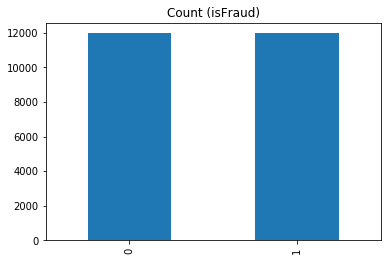

In [55]:
df_class_0_under = df_class_0.sample(count_class_1)
X = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(X.isfraud.value_counts())

X.isfraud.value_counts().plot(kind='bar', title='Count (isFraud)');

- Stratification will ensure that the samples evenly based on sample classes so that training set and validation set have similar ratio of classes

In [56]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:13],
                                                    X.iloc[:,-1],
                                                    stratify = X['isfraud'], test_size=0.3)

In [57]:
#checking the split
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

0    0.5
1    0.5
Name: isfraud, dtype: float64
0    0.5
1    0.5
Name: isfraud, dtype: float64


###  Scaling, Standardizing and Transformation are important steps of numeric feature and they used to treat skewed features and rescale them for modelling

In [58]:
le = LabelEncoder()

In [59]:
X_train["acqcountry"]=le.fit_transform(X_train["acqcountry"])
X_test["acqcountry"]= le.transform(X_test["acqcountry"])

X_train["merchantcountrycode"]=le.fit_transform(X_train["merchantcountrycode"])
X_test["merchantcountrycode"]= le.transform(X_test["merchantcountrycode"])

X_train["merchantcategorycode"]=le.fit_transform(X_train["merchantcategorycode"])
X_test["merchantcategorycode"]= le.transform(X_test["merchantcategorycode"])

X_train["transactiontype"]=le.fit_transform(X_train["transactiontype"])
X_test["transactiontype"]= le.transform(X_test["transactiontype"])


In [60]:
#Scaling the numerical features
categorical_columns = ['acqcountry','merchantcountrycode', 'posentrymode', 'posconditioncode',
                       'merchantcategorycode','cardpresent','transactiontype' ,'expirationdatekeyinmatch',
                       'correct_cvv']

X_train_1 = X_train[categorical_columns]
X_test_1 = X_test[categorical_columns]

scaler = StandardScaler()
standardized_numeric_data = scaler.fit_transform(X_train.drop(columns=categorical_columns))
X_train_final = np.concatenate((standardized_numeric_data,np.array(X_train_1)),axis=1)
standardized_numeric_data = scaler.transform(X_test.drop(columns=categorical_columns))
X_test_final = np.concatenate((standardized_numeric_data,np.array(X_test_1)),axis=1)

## Models

In [164]:
# from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

- I performed a Gridesearch to get hyperparameter tuning parameters FOR SVC. C= 1 provide the best results 

In [165]:
#model fitting
svc = svm.SVC(class_weight= 'balanced',C=1)
svc.fit(X_train_final, y_train)

SVC(C=1, class_weight='balanced')

In [166]:
y_predict = svc.predict(X_test_final)
svc_cm = [y_test, y_predict]

In [167]:
confusion_matrix(y_test,y_predict)

array([[2652,  938],
       [1541, 2049]], dtype=int64)

In [168]:
accuracy = accuracy_score(y_test,y_predict)
print(accuracy)

0.6547353760445682


In [169]:

report = classification_report(y_test,y_predict)
print(report)


              precision    recall  f1-score   support

           0       0.63      0.74      0.68      3590
           1       0.69      0.57      0.62      3590

    accuracy                           0.65      7180
   macro avg       0.66      0.65      0.65      7180
weighted avg       0.66      0.65      0.65      7180



## Logistic Regression

- Logistic regression utilizes a sigmoid function and works best on binary classification problems

In [170]:
LR = LogisticRegression().fit(X_train_final, y_train)

In [171]:
y_predict = LR.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
lr_cm = [y_test, y_predict]
print(accuracy)

0.6445682451253482


In [172]:
confusion_matrix(y_test,y_predict)

array([[2456, 1134],
       [1418, 2172]], dtype=int64)

In [173]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.68      0.66      3590
           1       0.66      0.61      0.63      3590

    accuracy                           0.64      7180
   macro avg       0.65      0.64      0.64      7180
weighted avg       0.65      0.64      0.64      7180



## Random Forests

- Random Forests consists multiple decision trees. 
- Random forests perform well where a data has a large number of features that individually have weak predicative power but much stronger power collectively.

In [174]:
RF = RandomForestClassifier().fit(X_train_final, y_train)
y_predict = RF.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
rf_cm = [y_test, y_predict]
print(accuracy)

0.6827298050139275


In [175]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      3590
           1       0.69      0.67      0.68      3590

    accuracy                           0.68      7180
   macro avg       0.68      0.68      0.68      7180
weighted avg       0.68      0.68      0.68      7180



In [176]:
confusion_matrix(y_test,y_predict)

array([[2495, 1095],
       [1183, 2407]], dtype=int64)

## Decision Tree 

In [177]:
from sklearn.tree import DecisionTreeClassifier

In [178]:
DT = DecisionTreeClassifier(random_state=1234).fit(X_train_final, y_train)

In [179]:
y_predict = DT.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
dt_cm = [y_test, y_predict]
print(accuracy)

0.6125348189415042


In [180]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      3590
           1       0.61      0.61      0.61      3590

    accuracy                           0.61      7180
   macro avg       0.61      0.61      0.61      7180
weighted avg       0.61      0.61      0.61      7180



## K Nearest Neighbor

- KNN is a non-parametric learning algorithm, it will not assume anything about the underlying data.
- KNN is useful for Real world data like Transaction Fraudulent detection


In [181]:
from sklearn.neighbors import KNeighborsClassifier

In [182]:
KN = KNeighborsClassifier().fit(X_train_final, y_train)

In [183]:
y_predict = KN.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
kn_cm = [y_test, y_predict]
print(accuracy)

0.6667130919220056


In [184]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.66      0.66      3590
           1       0.66      0.68      0.67      3590

    accuracy                           0.67      7180
   macro avg       0.67      0.67      0.67      7180
weighted avg       0.67      0.67      0.67      7180



## XGBoost :Gradient boosted decision trees
- XGBoost performe well on binary classification problems with a severe class imbalance.

In [185]:
XG = XGBClassifier().fit(X_train_final, y_train)

[14:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [186]:
y_predict = XG.predict(X_test_final)
accuracy = accuracy_score(y_test,y_predict)
xg_cm = [y_test, y_predict]
print(accuracy)

0.6956824512534819


In [187]:
confusion_matrix(y_test,y_predict)

array([[2484, 1106],
       [1079, 2511]], dtype=int64)

In [188]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.69      0.69      3590
           1       0.69      0.70      0.70      3590

    accuracy                           0.70      7180
   macro avg       0.70      0.70      0.70      7180
weighted avg       0.70      0.70      0.70      7180



In [189]:
def plot_roc(models):
    fig = plt.figure(figsize=(15,10)) 
    for key, value in models.items():
        fpr, tpr, _ = roc_curve(value[0], value[1])
        sns.lineplot(x=fpr, y=tpr, label=key)

    ax = sns.lineplot(x=[0, 0.5, 1], y=[0, 0.5, 1])
    ax.lines[len(models)].set_linestyle("--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')

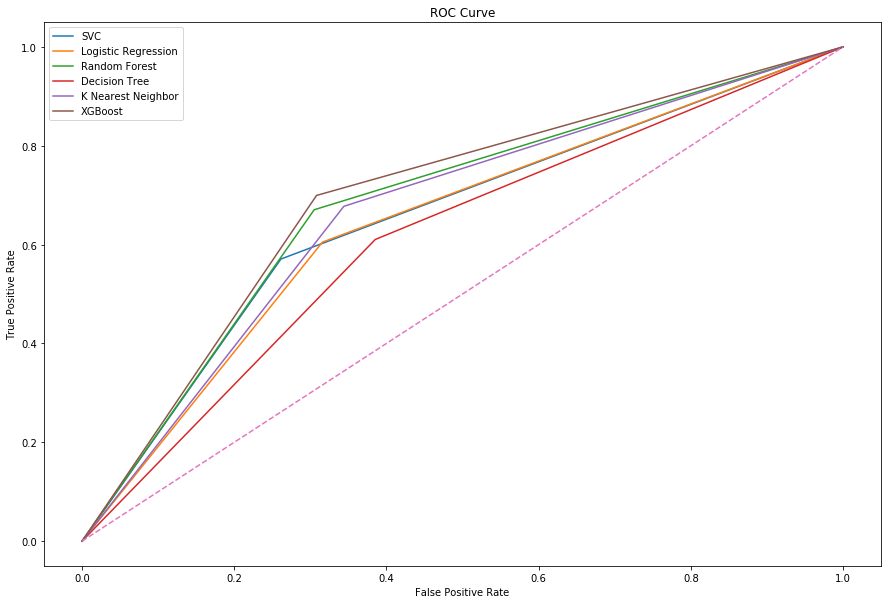

In [190]:
results = { 'SVC' :svc_cm,
            'Logistic Regression': lr_cm,      
            'Random Forest': rf_cm,
            'Decision Tree' :dt_cm,
            'K Nearest Neighbor': kn_cm, 
            'XGBoost': xg_cm }
plot_roc(results)

## XGBoost Model performed best out of all 6 models
- K Nearest Neighbor and Decision tree also performed well compared to other model with an accuracy of 67% and 68%
- We had to Under sample large portion of the data,despite that we got an accuracy of 70%.
- This model can't be used in reasl world Fruadulent detection.